In [37]:
import importlib.util
import numpy as np
from scipy.constants import c
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [38]:
um = 1e-6
nm = 1e-9
valor_lambda = 1550*nm
start_wavelenth = 1500*nm
stop_wavelenth = 1600*nm
number_point = 1000

file = 'ring_ressonator_Ideal'

In [39]:
ng = 4.3458796
neff = 2.35317
FSR = [1*nm, 10*nm, 20*nm]

r = 4.4*um
Lr = np.zeros(len(FSR))

for i in range (len(FSR)):
    Lr[i] = valor_lambda**2/(ng*FSR[i])

    print(f'Para FSR = {FSR[i]/nm:.2f}nm:\nComprimento total do anel = {Lr[i]/um:.2f}\u03BCm\n')

Para FSR = 1.00nm:
Comprimento total do anel = 552.82μm

Para FSR = 10.00nm:
Comprimento total do anel = 55.28μm

Para FSR = 20.00nm:
Comprimento total do anel = 27.64μm



In [40]:
lumapiFile = "C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
spec = importlib.util.spec_from_file_location("lumapi", lumapiFile)
lumapi = importlib.util.module_from_spec(spec)
spec.loader.exec_module(lumapi)

interApi = lumapi.INTERCONNECT(hide = False)

In [41]:
x_ona = 0
y_ona = 0

x_acoplador_direcional_sup = 25
y_acoplador_direcional_sup = 200

x_acoplador_direcional_inf = 25
y_acoplador_direcional_inf = 500

x_waveguide_esquerdo = -150
y_waveguide_esquerdo = 350

x_waveguide_direito = 200
y_waveguide_direito = 350



In [42]:
interApi.switchtolayout()

interApi.select('ONA')
interApi.delete()

interApi.addelement('Optical Network Analyzer')
interApi.set('name', 'ONA')
interApi.setposition('ONA', x_ona, y_ona)
interApi.set('number of input ports', 2)
interApi.set('input parameter', 'start and stop')
interApi.set('start frequency', c/start_wavelenth)
interApi.set('stop frequency', c/stop_wavelenth)
interApi.set('number of points', number_point)

In [43]:
interApi.switchtolayout()

interApi.select('Acoplador_Direcional_sup')
interApi.delete()
interApi.select('Acoplador_Direcional_inf')
interApi.delete()

interApi.addelement('Waveguide Coupler')
interApi.set('name', 'Acoplador_Direcional_sup')
interApi.setposition('Acoplador_Direcional_sup', x_acoplador_direcional_sup, y_acoplador_direcional_sup)

interApi.addelement('Waveguide Coupler')
interApi.set('name', 'Acoplador_Direcional_inf')
interApi.setposition('Acoplador_Direcional_inf', x_acoplador_direcional_inf, y_acoplador_direcional_inf)

In [44]:
interApi.switchtolayout()

interApi.select('WGD_esquerdo')
interApi.delete()
interApi.select('WGD_direito')
interApi.delete()

interApi.addelement('Straight Waveguide')
interApi.set('name', 'WGD_esquerdo')
interApi.setposition('WGD_esquerdo', x_waveguide_esquerdo, y_waveguide_esquerdo)
interApi.set('length', Lr[2]/2)
interApi.set('effective index 1', neff)
interApi.set('group index 1', ng)
interApi.setnamed('WGD_esquerdo', 'Rotated', 45)

interApi.addelement('Straight Waveguide')
interApi.set('name', 'WGD_direito')
interApi.setposition('WGD_direito', x_waveguide_direito, y_waveguide_direito)
interApi.set('length', Lr[2]/2)
interApi.set('effective index 1', neff)
interApi.set('group index 1', ng)
interApi.setnamed('WGD_direito', 'Rotated', 45)

In [45]:
interApi.connect('ONA', 'output', 'Acoplador_Direcional_sup', 'port 1')
interApi.connect('Acoplador_Direcional_sup', 'port 2', 'WGD_esquerdo', 'port 1')
interApi.connect('Acoplador_Direcional_sup', 'port 4', 'WGD_direito', 'port 1')
interApi.connect('WGD_esquerdo', 'port 2', 'Acoplador_Direcional_inf', 'port 1')
interApi.connect('WGD_direito', 'port 2', 'Acoplador_Direcional_inf', 'port 3')
interApi.connect('Acoplador_Direcional_sup', 'port 3', 'ONA', 'input 1')
interApi.connect('Acoplador_Direcional_inf', 'port 2', 'ONA', 'input 2')

1.0

In [46]:
interApi.save(file)

In [47]:
interApi.run(1)

In [48]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')

wavelength_1 = np.array(FSR_1['wavelength']).flatten()
transmission_1 = np.array(FSR_1['TE gain (dB)'])

wavelength_2 = np.array(FSR_2['wavelength']).flatten()
transmission_2 = np.array(FSR_2['TE gain (dB)'])  

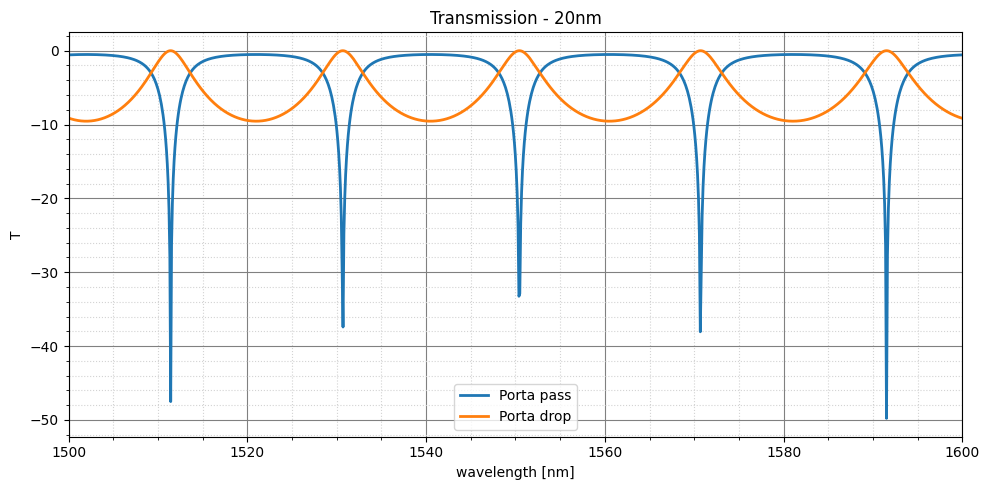

In [49]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

plt.plot(wavelength_1/nm, transmission_1, label = 'Porta pass', linewidth=2)
plt.plot(wavelength_2/nm, transmission_2, label = 'Porta drop', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([start_wavelenth/nm, stop_wavelenth/nm])
plt.title(r'Transmission - 20nm')
plt.legend(loc='best')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 20nm.png')
plt.show()

In [50]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1_20 = np.array(FSR_1['wavelength']).flatten()
fsrplot_1_20 = np.array(FSR_1["TE free spectral range (m)"])

wavelength_2_20 = np.array(FSR_2['wavelength']).flatten()
fsrplot_2_20 = np.array(FSR_2["TE free spectral range (m)"]) 

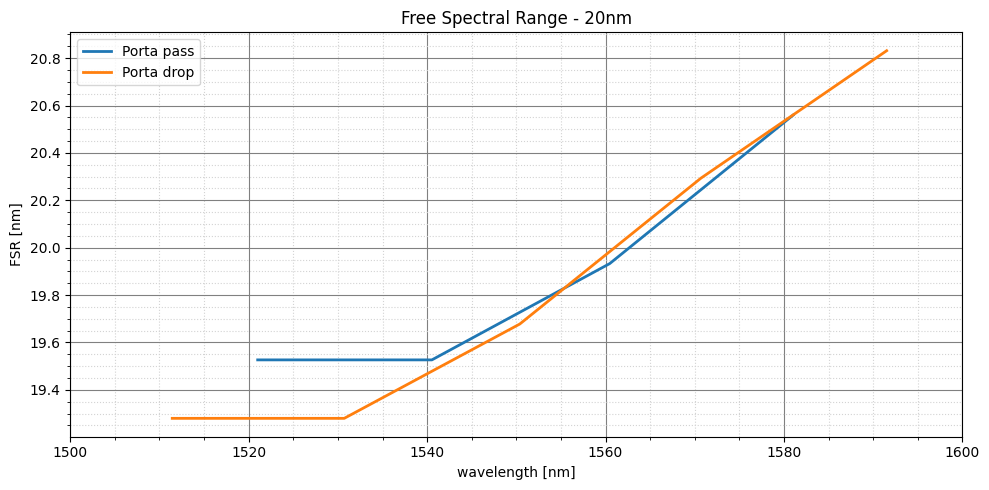

In [51]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)

plt.plot(wavelength_1_20/nm, fsrplot_1_20/nm, label = 'Porta pass', linewidth=2)
plt.plot(wavelength_2_20/nm, fsrplot_2_20/nm, label = 'Porta drop', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('FSR [nm]')
plt.xlim([start_wavelenth/nm, stop_wavelenth/nm])
plt.title(r'Free Spectral Range - 20nm')
plt.legend(loc='best')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('FSR - 20nm.png')
plt.show()

In [52]:
interApi.switchtolayout()

interApi.select('WGD_esquerdo')
interApi.set('length', Lr[1]/2)
interApi.select('WGD_direito')
interApi.set('length', Lr[1]/2)

In [53]:
interApi.save(file)

In [54]:
interApi.run(1)

In [55]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')

wavelength_1 = np.array(FSR_1['wavelength']).flatten()
transmission_1 = np.array(FSR_1['TE gain (dB)'])

wavelength_2 = np.array(FSR_2['wavelength']).flatten()
transmission_2 = np.array(FSR_2['TE gain (dB)'])  

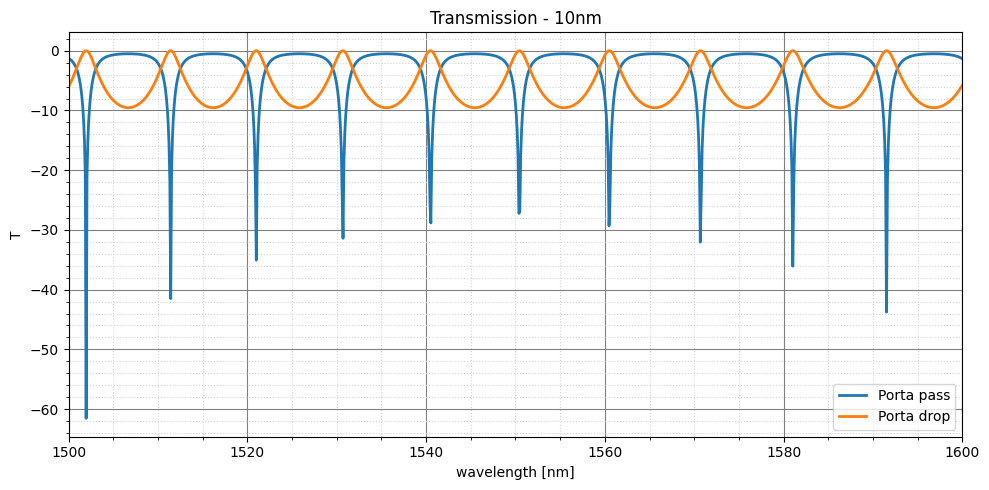

In [56]:
fig2 = plt.figure(figsize=(10,5))
ax2 = fig2.add_subplot(111)

plt.plot(wavelength_1/nm, transmission_1, label = 'Porta pass', linewidth=2)
plt.plot(wavelength_2/nm, transmission_2, label = 'Porta drop', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([start_wavelenth/nm, stop_wavelenth/nm])
plt.title(r'Transmission - 10nm')
plt.legend(loc='best')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 10nm.png')
plt.show()

In [57]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1_10 = np.array(FSR_1['wavelength']).flatten()
fsrplot_1_10 = np.array(FSR_1["TE free spectral range (m)"])

wavelength_2_10 = np.array(FSR_2['wavelength']).flatten()
fsrplot_2_10 = np.array(FSR_2["TE free spectral range (m)"]) 

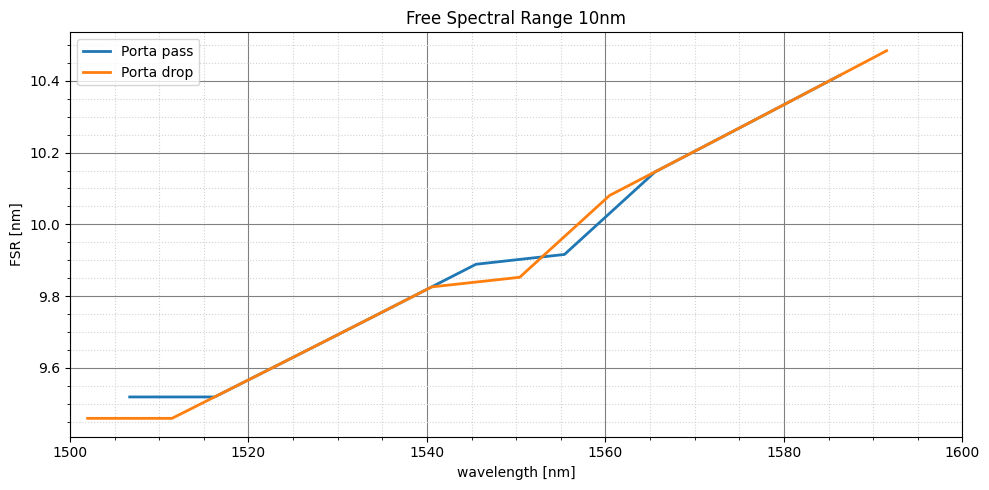

In [58]:
fig2 = plt.figure(figsize=(10,5))
ax2 = fig2.add_subplot(111)

plt.plot(wavelength_1_10/nm, fsrplot_1_10/nm, label = 'Porta pass', linewidth=2)
plt.plot(wavelength_2_10/nm, fsrplot_2_10/nm, label = 'Porta drop', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('FSR [nm]')
plt.xlim([start_wavelenth/nm, stop_wavelenth/nm])
plt.title(r'Free Spectral Range 10nm')
plt.legend(loc='best')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('FSR - 10nm.png')
plt.show()

In [59]:
interApi.switchtolayout()

interApi.select('WGD_esquerdo')
interApi.set('length', Lr[0]/2)
interApi.select('WGD_direito')
interApi.set('length', Lr[0]/2)

In [60]:
interApi.save(file)

In [61]:
interApi.run(1)

In [62]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/gain')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/gain')

wavelength_1 = np.array(FSR_1['wavelength']).flatten()
transmission_1 = np.array(FSR_1['TE gain (dB)'])

wavelength_2 = np.array(FSR_2['wavelength']).flatten()
transmission_2 = np.array(FSR_2['TE gain (dB)'])  

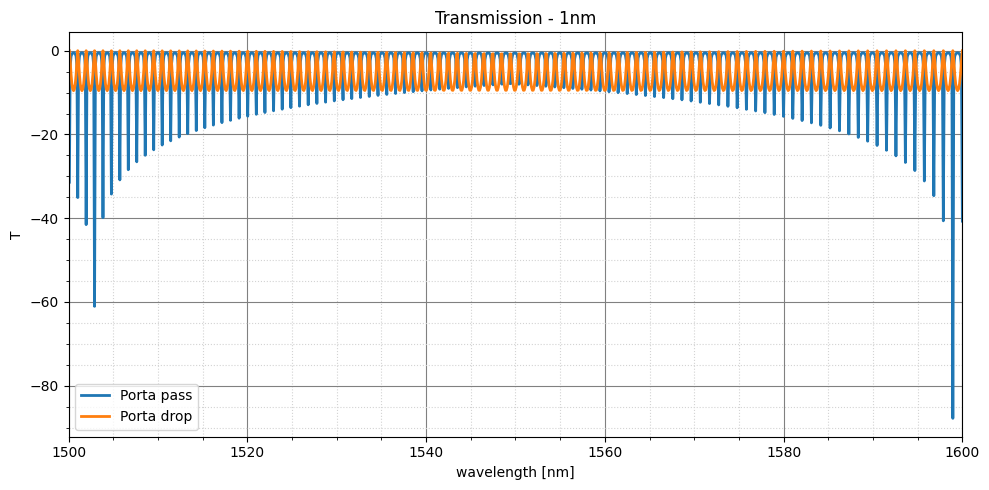

In [63]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(111)

plt.plot(wavelength_1/nm, transmission_1, label = 'Porta pass', linewidth=2)
plt.plot(wavelength_2/nm, transmission_2, label = 'Porta drop', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('T')
plt.xlim([start_wavelenth/nm, stop_wavelenth/nm])
plt.title(r'Transmission - 1nm')
plt.legend(loc='best')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('T - 1nm.png')
plt.show()

In [64]:
FSR_1 = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2 = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1_1 = np.array(FSR_1['wavelength']).flatten()
fsrplot_1_1 = np.array(FSR_1["TE free spectral range (m)"])

wavelength_2_1 = np.array(FSR_2['wavelength']).flatten()
fsrplot_2_1 = np.array(FSR_2["TE free spectral range (m)"])  

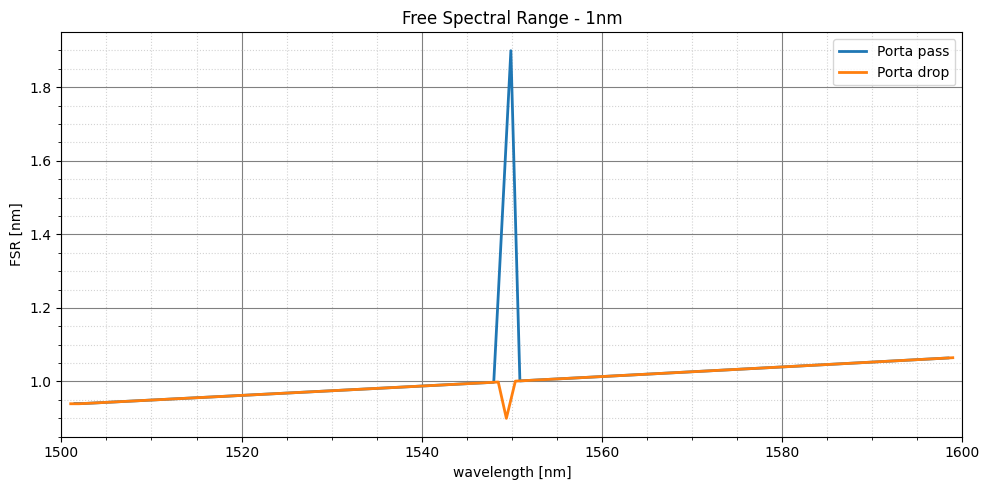

In [65]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(111)

plt.plot(wavelength_1_1/nm, fsrplot_1_1/nm, label = 'Porta pass', linewidth=2)
plt.plot(wavelength_2_1/nm, fsrplot_2_1/nm, label = 'Porta drop', linewidth=2)

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('FSR [nm]')
plt.xlim([start_wavelenth/nm, stop_wavelenth/nm])
plt.title(r'Free Spectral Range - 1nm')
plt.legend(loc='best')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('FSR - 1nm.png')
plt.show()

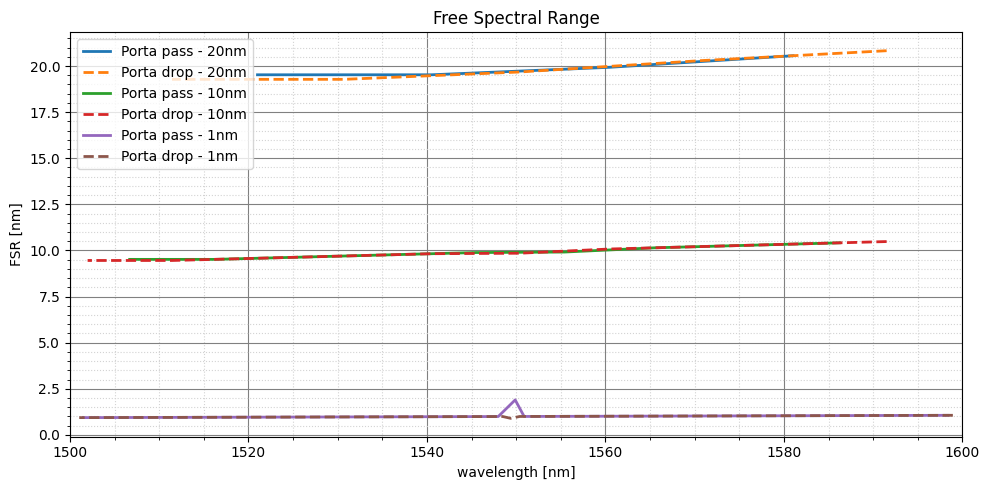

In [66]:
fig4 = plt.figure(figsize=(10,5))
ax4 = fig4.add_subplot(111)

plt.plot(wavelength_1_20/nm, fsrplot_1_20/nm, label = 'Porta pass - 20nm', linewidth=2)
plt.plot(wavelength_2_20/nm, fsrplot_2_20/nm, label = 'Porta drop - 20nm', linewidth=2, linestyle='--')
plt.plot(wavelength_1_10/nm, fsrplot_1_10/nm, label = 'Porta pass - 10nm', linewidth=2)
plt.plot(wavelength_2_10/nm, fsrplot_2_10/nm, label = 'Porta drop - 10nm', linewidth=2, linestyle='--')
plt.plot(wavelength_1_1/nm, fsrplot_1_1/nm, label = 'Porta pass - 1nm', linewidth=2)
plt.plot(wavelength_2_1/nm, fsrplot_2_1/nm, label = 'Porta drop - 1nm', linewidth=2, linestyle='--')

plt.axvline(x=valor_lambda, color='k', linestyle='--')

plt.xlabel(r'wavelength [nm]')
plt.ylabel('FSR [nm]')
plt.xlim([start_wavelenth/nm, stop_wavelenth/nm])
plt.title(r'Free Spectral Range')
plt.legend(loc='best')
plt.grid(which='major', color='gray', linestyle='-')
plt.grid(which='minor', color='lightgray', linestyle=':')

plt.minorticks_on()

plt.tight_layout()
plt.savefig('FSR.png')
plt.show()